# News Source Comparison
This file will attempt to disprove the null hypothesis outlined in the README. It will also attempt to duplicate the findings from the Buzzfeed article, as well as explore other interesting aspects of the dataset.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
from scipy.stats import spearmanr, kendalltau

buzzfeed_df = pd.read_csv('../csv_collection/cleaned_buzzfeed_data.csv')

display(buzzfeed_df.head(3))

,account_id,post_id,category,page,post_url,date_published,post_type,rating,debate,share_count,reaction_count,comment_count,engagement_score
0,184096565021911,1035057923259100,mainstream,ABC News Politics,https://www.facebook.com/ABCNewsPolitics/posts...,2016-09-19,video,no factual content,NaN,0.0,146.0,15.0,44.00
1,184096565021911,1035269309904628,mainstream,ABC News Politics,https://www.facebook.com/ABCNewsPolitics/posts...,2016-09-19,link,mostly true,NaN,1.0,33.0,34.0,26.25
2,184096565021911,1035305953234297,mainstream,ABC News Politics,https://www.facebook.com/ABCNewsPolitics/posts...,2016-09-19,link,mostly true,NaN,34.0,63.0,27.0,63.25


Here I will attempt to duplicate the findings in the BuzzFeed article

In [2]:
# Left calculation:
left_misleading = buzzfeed_df[(buzzfeed_df['category'] == 'left') & buzzfeed_df['rating'].isin(['mostly false', 'mixture of true and false' ])]
left_posts = buzzfeed_df[buzzfeed_df['category'] == 'left']
left_percent_misleading = (len(left_misleading) * 100) / len(left_posts)

# Right calculation:
right_misleading = buzzfeed_df[(buzzfeed_df['category'] == 'right') & buzzfeed_df['rating'].isin(['mostly false', 'mixture of true and false' ])]
right_posts = buzzfeed_df[buzzfeed_df['category'] == 'right']
right_percent_misleading = (len(right_misleading) * 100) / len(right_posts)

print(f"{left_percent_misleading:.3f}% of posts from left sources are mostly false or a mixture of true and false.")
print(f"{right_percent_misleading:.3f}% of posts from right sources are mostly false or a mixture of true and false.")
print('This duplicates the results from the BuzzFeed analysis.')

19.108% of posts from left sources are mostly false or a mixture of true and false.
37.688% of posts from right sources are mostly false or a mixture of true and false.
This duplicates the results from the BuzzFeed analysis.


## Null hypothesis
Here I will attempt to disprove that the correlation between factuality and average engagement, has no statistical difference between right and left leaning publications.

Publications, Engagement, Factuality Table:


,category,rating,count,total_engagement,average_engagement,rating_num
0,left,mixture of true and false,68,1327089.50,19516.022059,1
1,left,mostly false,22,279340.50,12697.295455,2
2,left,mostly true,265,3376622.00,12741.969811,0
3,mainstream,mixture of true and false,8,29589.75,3698.718750,1
4,mainstream,mostly true,1085,451457.25,416.089631,0
5,right,mixture of true and false,169,341221.00,2019.059172,1
6,right,mostly false,82,268026.50,3268.615854,2
7,right,mostly true,319,420293.00,1317.532915,0


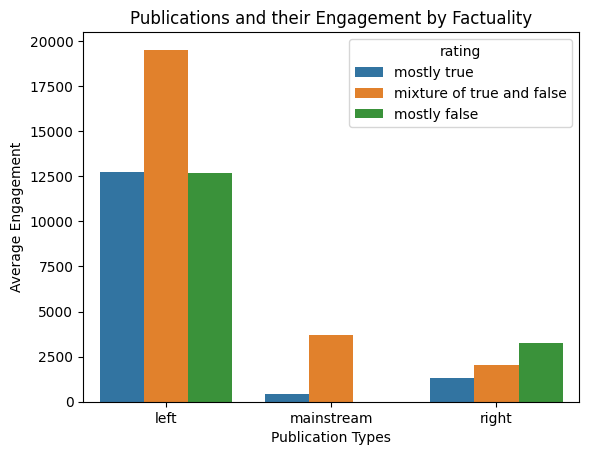

In [3]:
buzzfeed_df = buzzfeed_df[buzzfeed_df['rating'].isin(['mostly true', 'mixture of true and false', 'mostly false' ])]

# Creating an aggregated Data Frame between publications and engagement.
engagement_df = (
    buzzfeed_df.groupby(['category', 'rating']).agg(
        count=('rating', 'size'),
        total_engagement=('engagement_score', 'sum'),
        average_engagement=('engagement_score', 'mean')
    ).reset_index())

# Ordering by factuality:
rating_order = ["mostly true", "mixture of true and false", "mostly false"]
engagement_df['rating'] = pd.Categorical(engagement_df['rating'], categories=rating_order, ordered=True)
engagement_df['rating_num'] = engagement_df['rating'].cat.codes

sns.barplot(
    x='category',
    y='average_engagement',
    hue='rating',
    data=engagement_df
)
plt.xlabel('Publication Types')
plt.ylabel('Average Engagement')
plt.title('Publications and their Engagement by Factuality')

print('Publications, Engagement, Factuality Table:')
display(engagement_df.head(9))
plt.show();


As seen from the graph, there is a visually obvious correlation for right-leaning media, between the correlation of un-factual information and average engagement. I'll attempt to statistically prove that correlation below:

In [4]:
# Splitting the df into left and right groups:
left_df = engagement_df[engagement_df['category'] == 'left']
right_df = engagement_df[engagement_df['category'] == 'right']


# Using the Spearman rank, to prove the correlation between two variables:
left_spear_corr, left_spear_p = spearmanr(left_df['rating_num'], left_df['average_engagement'])
right_spear_corr, right_spear_p = spearmanr(right_df['rating_num'], right_df['average_engagement'])

# Double testing with the Kendall correlation:
left_kendall_corr, left_kendall_p = kendalltau(left_df['rating_num'], left_df['average_engagement'])
right_kendall_corr, right_kendall_p = kendalltau(right_df['rating_num'], right_df['average_engagement'])

# Displaying results
print(f"LEFT — Spearman: ρ = {left_spear_corr:.3f}, p = {left_spear_p:.3f} | Kendall: τ = {left_kendall_corr:.3f}, p = {left_kendall_p:.3f}")
print(f"RIGHT — Spearman: ρ = {right_spear_corr:.3f}, p = {right_spear_p:.3f} | Kendall: τ = {right_kendall_corr:.3f}, p = {right_kendall_p:.3f}")


LEFT — Spearman: ρ = -0.500, p = 0.667 | Kendall: τ = -0.333, p = 1.000
RIGHT — Spearman: ρ = 1.000, p = 0.000 | Kendall: τ = 1.000, p = 0.333


The above calculations show that for the Left publications: Spearman's Rho and Kendals Tau show negative correlations, meaning that as factuality decreases, average engagement tends to decrease as well. However these p values are higher than 0.05, so they are not statiscally significant, they just highlight a possible correlation.

For the Right publications: The Rho and Tau results show perfect 1.0 correlations, with a very low p value from Spearman, but not Kendall. Overall, it is fair to say that there is a statistically significant difference between the types of media, Left and Right. Right facing publications tend to gain more engagement on average, the less factual they are. 

I'll now graph these two correlations for even more obvious viewing:

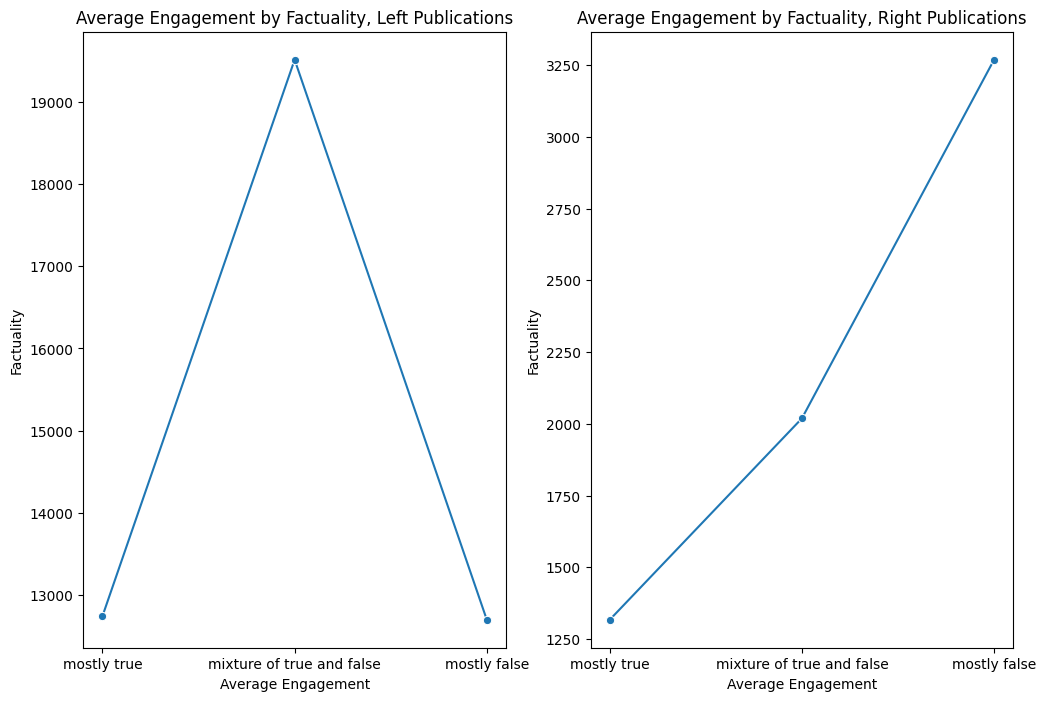

In [5]:
left_df['rating'] = pd.Categorical(left_df['rating'], ['mostly true', 'mixture of true and false', 'mostly false'], ordered=True)
right_df['rating'] = pd.Categorical(right_df['rating'], ['mostly true', 'mixture of true and false', 'mostly false'], ordered=True)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
ax1 = sns.lineplot(
    x='rating',
    y='average_engagement',
    data=left_df,
    marker='o'
)
plt.xlabel('Average Engagement')
plt.ylabel('Factuality')
plt.title('Average Engagement by Factuality, Left Publications')

plt.subplot(1, 2, 2)
ax2 = sns.lineplot(
    x='rating',
    y='average_engagement',
    data=right_df,
    marker='o'
)
plt.xlabel('Average Engagement')
plt.ylabel('Factuality')
plt.title('Average Engagement by Factuality, Right Publications')

plt.show();

As shown the Spearman and Kendal statistical test, and the clear trends of the above graphs, there is a significant difference in the correlation between factuality and post-engagement between Right and Left leaning publications. The null hypothesis has been disproven, and the alternative hypothesis has been proven. 